### <img src="icons/resized/helper_functions.png" style="height:50px;display:inline"> Useful Functions
1) train - Receives hyperparameters and creates a model with these parameters. Calculates model's training loss and returns the trained model.  
2) calculate_accuracy - With this function we can evaluate the models while training (training accuracy), post-trained models (validation accuracy) and finally                          models that we are satisfied with (test accuracy)
3) objective - similar function to train() with some changes for optuna compatability.
4) create_results_file - Creates a file with all the hyperparameters and results for each run that we try in our strategy (for example random search).
5) 

### <img src="icons/resized/library.png" style="height:50px;display:inline"> Libs
Import libraries for the project: 

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os
import cv2
import time
from tqdm.notebook import tqdm
import torch.optim as optim
import optuna
from torchsummary import summary
from PIL import Image
%matplotlib inline
from utils import CNN_plot_utils as CNNplt
import csv

### <img src="icons/resized/dataset.png" style="height:50px;display:inline"> Dataset
Loading dataset as train, validation and test:

train dataset has 39116 samples
validation dataset has 10861 samples
test dataset has 4328 samples


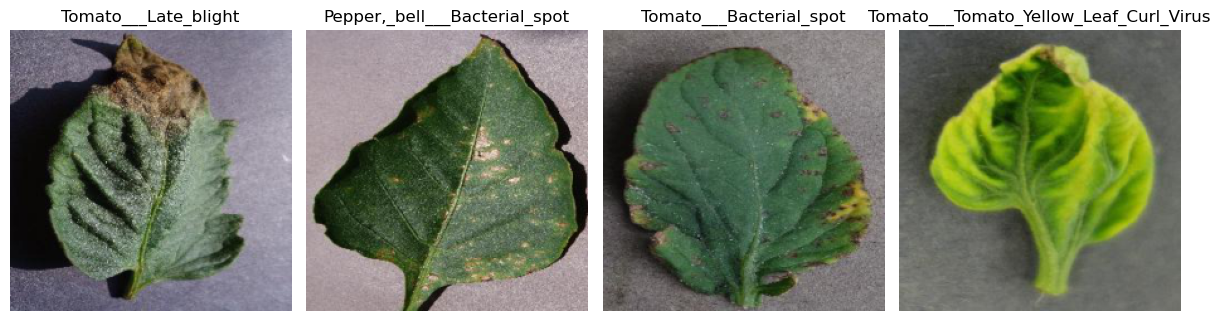

In [17]:
#local dir:
local_root_dir = 'Dataset/PlantVillage 2'

train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

sample_dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
# loading datasets:
train_dataset = datasets.ImageFolder(root=local_root_dir + '/train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root=local_root_dir + '/val', transform=valid_transform)
test_dataset = datasets.ImageFolder(root=local_root_dir + '/test', transform=valid_transform)

train_size = len(train_dataset)
valid_size = len(valid_dataset)
test_size = len(test_dataset)

print(f"train dataset has {train_size} samples\nvalidation dataset has {valid_size} samples\ntest dataset has {test_size} samples")

sample_dataset = datasets.ImageFolder(root=local_root_dir + '/train', transform=sample_dataset_transform)
sample_dataset_loader = torch.utils.data.DataLoader(dataset=sample_dataset, batch_size=4, shuffle=True)

iterator = iter(sample_dataset_loader)

batch_images, batch_labels = next(iterator)
fig, axes = plt.subplots(1, len(batch_images), figsize=(12, 4))
for i, image in enumerate(batch_images):
    axes[i].imshow(image.permute(1, 2, 0))  # permute to (H, W, C) for display
    axes[i].axis('off')
    axes[i].set_title(train_dataset.classes[batch_labels[i]])
plt.tight_layout()
plt.show()


In [438]:
# train method:

def train_model_for_test(trainloader, epochs, learning_rate, p, model_loss, model_accuracy, model_name_to_save):
    model = plantDiseaseCNN(p).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in tqdm(range(1, epochs + 1, 1), leave=True):
        model.train()  # put in training mode, turn on Dropout, BatchNorm uses batch's statistics
        running_loss = 0.0
        epoch_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward pass
            
            loss = criterion(outputs, labels)  # calculate the loss
            
            optimizer.zero_grad()  # zero the parameter gradients
            loss.backward()  # backpropagation
            optimizer.step()  # update parameters

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)
        model_loss.append(running_loss)

        # Calculate training/test set accuracy of the existing model
        train_accuracy, _ = calculate_accuracy(model, trainloader, device)
        model_accuracy.append(train_accuracy)

        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # save model
        if epoch % 10 == 0:
            print('==> Saving model ...')
            state = {
                'net': model.state_dict(),
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/{model_name_to_save}.pth')

    print('==> Finished Training ...')
    if epoch > 10 and epoch % 10 != 0:
        state = {
                'net': model.state_dict(),
                'epoch': epoch,
                }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/{model_name_to_save}.pth')
    return model


#  function for accuracy calculations:

def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([38, 38], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

# optuna tuning:

def objective(trial):
    epochs = 5
    p = trial.suggest_float("p", 0.1, 0.5, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)  # log=True, will use log scale to interplolate between lr
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    batch_size = trial.suggest_int("batch_size", 32, 128, log=True)
    model = plantDiseaseCNN(p).to(device)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    n_train_examples = len(train_loader.dataset)
    n_valid_examples = len(valid_loader.dataset)
    # alternative version
    # optimizer = trial.suggest_categorical("optimizer", [optim.Adam, optim.RMSprop, optim.SGD])
    for epoch in range(epochs):
        model.train()
        #for batch_idx, (data, target) in enumerate(train_loader):
        for i, data in enumerate(train_loader, 0):
            # Limiting training data for faster epochs.
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            
            output = model(inputs)
            loss = criterion(output, target)  # calculate the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            #for batch_idx, (data, target) in enumerate(valid_loader):
            for i, data in enumerate(valid_loader, 0):
                # Limiting validation data.
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)
                #data, target = data.view(data.size(0), -1).to(device), target.to(device)
                output = model(inputs)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = (correct / min(len(valid_loader.dataset), n_valid_examples)) * 100

        # report back to Optuna how far it is (epoch-wise) into the trial and how well it is doing (accuracy)
        trial.report(accuracy, epoch)  

        # then, Optuna can decide if the trial should be pruned
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    #normalize = transforms.Normalize(
    #mean=[0.485, 0.456, 0.406],
    #std=[0.229, 0.224, 0.225]
    #)
    preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), ])
    #normalize])

    if isinstance(image, torch.Tensor):
        # Convert the tensor to PIL Image
        image = transforms.ToPILImage()(image)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item()) 
    
def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

def layer_outputs(image, model):

    outputs = []
    names = []
        
    for layer in model.conv_layer:
    
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)  # take the mean
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize=(30, 50))

    for i in range(len(output_im)):
        a = fig.add_subplot(8, 4, i+1)
        imgplot = plt.imshow(output_im[i])
        a.set_axis_off()
        a.set_title(names[i].partition('(')[0], fontsize=30)
    plt.tight_layout()

def filter_outputs(image, model, layer_to_visualize):
    
    if layer_to_visualize < 0:
        layer_to_visualize += 23
    output = None
    name = None
    for count, layer in enumerate(model.conv_layer):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure(figsize=(5, 5))

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        ax = fig.add_subplot(int(np.sqrt(len(filters))), int(np.sqrt(len(filters))), i+1)
        ax.imshow(filters[i])
        ax.set_axis_off()
    print(f"layer name - {name.partition('(')[0]}")
    plt.tight_layout()

### <img src="icons/resized/device.png" style="height:50px;display:inline"> Device
Define the device:

In [9]:
if torch.backends.mps.is_built():
    print("using MPS")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("using Cuda")
    device = torch.device("cuda:0")
else:
    print("using CPUֹ")
    device = torch.device("cpu")

using MPS


### <img src="icons/resized/CNN_declaration.png" style="height:50px;display:inline"> Our CNN model:

In [10]:
class plantDiseaseCNN(nn.Module):
    def __init__(self, p = 0.1):
        """CNN Builder."""
        super(plantDiseaseCNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(4*4*16, 128),  
            nn.ReLU(inplace=True),
            nn.Dropout(p=p),
            nn.Linear(128, 38)
        )

    
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x


In [7]:
# Dimensions, Parameters and Size
print(f"Input dimension: 3 x 32 x 32")

dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = plantDiseaseCNN(p=0.2)
dummy_output = dummy_model.conv_layer(dummy_input)
print(f"output dimension: {dummy_output.shape}")

dummy_output = dummy_output.view(dummy_output.size(0),-1)
dummy_output_fc = dummy_model.fc_layer(dummy_output)
print(f"output dimension: {dummy_output_fc.shape}")

num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print(f"Number of trainable weights: {num_trainable_params}")

size_model = 0
for param in dummy_model.parameters():
  if param.data.is_floating_point():
    size_model += param.numel() * torch.finfo(param.data.dtype).bits
  else:
    size_model += param.numel() * torch.iinfo(param.data.dtype).bits

print(f"Model size: {size_model} [bit] | {size_model / 8e6:.2f} [MB]")

summary(dummy_model, (3,32,32))

Input dimension: 3 x 32 x 32
output dimension: torch.Size([1, 16, 4, 4])
output dimension: torch.Size([1, 38])
Number of trainable weights: 823798
Model size: 26361536 [bit] | 3.30 [MB]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 1

### <img src="icons/resized/random_serach.png" style="height:50px;display:inline"> Random Search Strategy:
Here we are trying get a general intuition about what hyperparameters we should use.

In [7]:
# define a list of hyperparameters:

learning_rate_list = [3e-4, 1e-4, 1e-3, 2e-3, 3e-3]
batch_size_list = [32, 64, 128]
p_dropout_list = [0.2, 0.3, 0.4, 0.5]
epochs = 5
results_list = []
random_search_model_best_params = {"lr": None, "p": None, "batch_size": None, "validation_accuracy": None}

iteration_counter = 0
max_experiments = 30
for i in range(max_experiments):
    iteration_counter += 1
    lr = np.random.choice(learning_rate_list, p=None)
    batch_size = int(np.random.choice(batch_size_list, p=[0.4, 0.4, 0.2]))
    p = np.random.choice(p_dropout_list, p=[0.4, 0.3, 0.2, 0.1])
    print(f"batch_size = {batch_size}\n lr = {lr}\n p = {p}")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    trained_model = train_model_for_test(train_loader, epochs, lr, p, [], [], "CNN_random_search_model")
    validation_accuracy, _ = calculate_accuracy(trained_model, valid_loader, device)
    print(f"calculating validation accuracy of trained model with batch_size = {batch_size}\n lr = {lr}")
    print(f"val accuracy:{validation_accuracy}")
    results_list_item = [validation_accuracy, batch_size, lr, p]
    results_list.append(results_list_item)
    print(f"iteration number {iteration_counter} out of {max_experiments}")

CNNplt.create_results_file("randomSearch_model", [], [], results_list, graph=False, parameters=True)


batch_size = 128
 lr = 0.001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.4244 | Training accuracy: 70.889% | Epoch Time: 111.06 secs
Epoch: 2 | Loss: 0.7435 | Training accuracy: 79.154% | Epoch Time: 109.32 secs
Epoch: 3 | Loss: 0.5554 | Training accuracy: 84.973% | Epoch Time: 108.89 secs
Epoch: 4 | Loss: 0.4585 | Training accuracy: 85.259% | Epoch Time: 107.86 secs
Epoch: 5 | Loss: 0.3895 | Training accuracy: 87.624% | Epoch Time: 107.91 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.001
val accuracy:88.04898259828745
iteration number 1 out of 30
batch_size = 128
 lr = 0.001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.4446 | Training accuracy: 71.071% | Epoch Time: 107.90 secs
Epoch: 2 | Loss: 0.7539 | Training accuracy: 82.148% | Epoch Time: 107.76 secs
Epoch: 3 | Loss: 0.5556 | Training accuracy: 83.746% | Epoch Time: 108.96 secs
Epoch: 4 | Loss: 0.4519 | Training accuracy: 84.019% | Epoch Time: 109.61 secs
Epoch: 5 | Loss: 0.3817 | Training accuracy: 88.606% | Epoch Time: 108.89 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.001
val accuracy:88.59221066200166
iteration number 2 out of 30
batch_size = 32
 lr = 0.002
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.7150 | Training accuracy: 65.919% | Epoch Time: 128.33 secs
Epoch: 2 | Loss: 1.0564 | Training accuracy: 63.309% | Epoch Time: 127.41 secs
Epoch: 3 | Loss: 0.8551 | Training accuracy: 79.931% | Epoch Time: 127.64 secs
Epoch: 4 | Loss: 0.7170 | Training accuracy: 81.169% | Epoch Time: 127.53 secs
Epoch: 5 | Loss: 0.6329 | Training accuracy: 81.964% | Epoch Time: 127.39 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:83.02182119510174
iteration number 3 out of 30
batch_size = 32
 lr = 0.003
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.7321 | Training accuracy: 58.388% | Epoch Time: 128.20 secs
Epoch: 2 | Loss: 1.1061 | Training accuracy: 69.744% | Epoch Time: 127.74 secs
Epoch: 3 | Loss: 0.8718 | Training accuracy: 81.450% | Epoch Time: 127.95 secs
Epoch: 4 | Loss: 0.7334 | Training accuracy: 84.239% | Epoch Time: 127.71 secs
Epoch: 5 | Loss: 0.6374 | Training accuracy: 84.899% | Epoch Time: 127.93 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:83.56504925881595
iteration number 4 out of 30
batch_size = 64
 lr = 0.001
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.5349 | Training accuracy: 69.307% | Epoch Time: 117.93 secs
Epoch: 2 | Loss: 0.8874 | Training accuracy: 79.001% | Epoch Time: 117.75 secs
Epoch: 3 | Loss: 0.6817 | Training accuracy: 65.733% | Epoch Time: 117.82 secs
Epoch: 4 | Loss: 0.5601 | Training accuracy: 84.492% | Epoch Time: 117.49 secs
Epoch: 5 | Loss: 0.4873 | Training accuracy: 87.079% | Epoch Time: 117.58 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 64
 lr = 0.001
val accuracy:86.78758861983242
iteration number 5 out of 30
batch_size = 128
 lr = 0.0001
 p = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 2.5761 | Training accuracy: 57.787% | Epoch Time: 109.67 secs
Epoch: 2 | Loss: 1.6846 | Training accuracy: 68.041% | Epoch Time: 108.89 secs
Epoch: 3 | Loss: 1.3182 | Training accuracy: 74.650% | Epoch Time: 108.88 secs
Epoch: 4 | Loss: 1.0968 | Training accuracy: 80.259% | Epoch Time: 108.75 secs
Epoch: 5 | Loss: 0.9454 | Training accuracy: 83.022% | Epoch Time: 109.12 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:83.1415155142252
iteration number 6 out of 30
batch_size = 32
 lr = 0.002
 p = 0.4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.8087 | Training accuracy: 49.366% | Epoch Time: 127.63 secs
Epoch: 2 | Loss: 1.1409 | Training accuracy: 71.411% | Epoch Time: 127.54 secs
Epoch: 3 | Loss: 0.9221 | Training accuracy: 78.047% | Epoch Time: 127.70 secs
Epoch: 4 | Loss: 0.7796 | Training accuracy: 76.772% | Epoch Time: 127.65 secs
Epoch: 5 | Loss: 0.6878 | Training accuracy: 84.357% | Epoch Time: 127.44 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:85.12107540742105
iteration number 7 out of 30
batch_size = 32
 lr = 0.0003
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.4688 | Training accuracy: 74.277% | Epoch Time: 127.77 secs
Epoch: 2 | Loss: 0.8234 | Training accuracy: 80.310% | Epoch Time: 127.48 secs
Epoch: 3 | Loss: 0.6276 | Training accuracy: 86.872% | Epoch Time: 128.12 secs
Epoch: 4 | Loss: 0.5209 | Training accuracy: 74.905% | Epoch Time: 127.98 secs
Epoch: 5 | Loss: 0.4487 | Training accuracy: 89.723% | Epoch Time: 127.79 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:89.54055795967221
iteration number 8 out of 30
batch_size = 32
 lr = 0.0001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6681 | Training accuracy: 74.839% | Epoch Time: 127.81 secs
Epoch: 2 | Loss: 0.8735 | Training accuracy: 82.181% | Epoch Time: 127.50 secs
Epoch: 3 | Loss: 0.6692 | Training accuracy: 85.990% | Epoch Time: 128.43 secs
Epoch: 4 | Loss: 0.5490 | Training accuracy: 86.520% | Epoch Time: 127.57 secs
Epoch: 5 | Loss: 0.4792 | Training accuracy: 90.157% | Epoch Time: 127.56 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:89.85360464045668
iteration number 9 out of 30
batch_size = 32
 lr = 0.0001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6944 | Training accuracy: 73.870% | Epoch Time: 127.42 secs
Epoch: 2 | Loss: 0.8835 | Training accuracy: 81.350% | Epoch Time: 127.59 secs
Epoch: 3 | Loss: 0.6623 | Training accuracy: 85.530% | Epoch Time: 127.68 secs
Epoch: 4 | Loss: 0.5463 | Training accuracy: 89.012% | Epoch Time: 127.60 secs
Epoch: 5 | Loss: 0.4619 | Training accuracy: 90.449% | Epoch Time: 127.86 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:89.97329895958015
iteration number 10 out of 30
batch_size = 32
 lr = 0.003
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6095 | Training accuracy: 65.638% | Epoch Time: 127.34 secs
Epoch: 2 | Loss: 0.9504 | Training accuracy: 77.329% | Epoch Time: 127.32 secs
Epoch: 3 | Loss: 0.7226 | Training accuracy: 81.892% | Epoch Time: 127.22 secs
Epoch: 4 | Loss: 0.6056 | Training accuracy: 83.733% | Epoch Time: 127.53 secs
Epoch: 5 | Loss: 0.5377 | Training accuracy: 86.604% | Epoch Time: 127.60 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:85.7103397477212
iteration number 11 out of 30
batch_size = 64
 lr = 0.0003
 p = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 2.0230 | Training accuracy: 67.136% | Epoch Time: 118.06 secs
Epoch: 2 | Loss: 1.1955 | Training accuracy: 75.378% | Epoch Time: 117.85 secs
Epoch: 3 | Loss: 0.9061 | Training accuracy: 78.842% | Epoch Time: 117.84 secs
Epoch: 4 | Loss: 0.7476 | Training accuracy: 83.876% | Epoch Time: 117.78 secs
Epoch: 5 | Loss: 0.6319 | Training accuracy: 86.647% | Epoch Time: 119.17 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0003
val accuracy:87.0822207899825
iteration number 12 out of 30
batch_size = 32
 lr = 0.001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.4278 | Training accuracy: 70.585% | Epoch Time: 127.80 secs
Epoch: 2 | Loss: 0.8074 | Training accuracy: 76.823% | Epoch Time: 127.95 secs
Epoch: 3 | Loss: 0.6295 | Training accuracy: 85.548% | Epoch Time: 127.57 secs
Epoch: 4 | Loss: 0.5257 | Training accuracy: 80.029% | Epoch Time: 127.81 secs
Epoch: 5 | Loss: 0.4525 | Training accuracy: 88.059% | Epoch Time: 127.73 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:87.8188012153577
iteration number 13 out of 30
batch_size = 32
 lr = 0.0003
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.3846 | Training accuracy: 69.102% | Epoch Time: 127.69 secs
Epoch: 2 | Loss: 0.7684 | Training accuracy: 81.432% | Epoch Time: 127.51 secs
Epoch: 3 | Loss: 0.5767 | Training accuracy: 82.296% | Epoch Time: 127.60 secs
Epoch: 4 | Loss: 0.4610 | Training accuracy: 88.064% | Epoch Time: 127.40 secs
Epoch: 5 | Loss: 0.3981 | Training accuracy: 89.229% | Epoch Time: 127.63 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:89.27354755547371
iteration number 14 out of 30
batch_size = 32
 lr = 0.001
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.5523 | Training accuracy: 74.236% | Epoch Time: 127.77 secs
Epoch: 2 | Loss: 0.9084 | Training accuracy: 76.598% | Epoch Time: 127.47 secs
Epoch: 3 | Loss: 0.7069 | Training accuracy: 83.132% | Epoch Time: 127.73 secs
Epoch: 4 | Loss: 0.6056 | Training accuracy: 86.622% | Epoch Time: 127.70 secs
Epoch: 5 | Loss: 0.5413 | Training accuracy: 88.312% | Epoch Time: 127.55 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:87.92928827916398
iteration number 15 out of 30
batch_size = 32
 lr = 0.001
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.5014 | Training accuracy: 63.578% | Epoch Time: 127.57 secs
Epoch: 2 | Loss: 0.8439 | Training accuracy: 71.689% | Epoch Time: 128.25 secs
Epoch: 3 | Loss: 0.6625 | Training accuracy: 78.451% | Epoch Time: 127.84 secs
Epoch: 4 | Loss: 0.5597 | Training accuracy: 81.174% | Epoch Time: 127.33 secs
Epoch: 5 | Loss: 0.4978 | Training accuracy: 86.313% | Epoch Time: 127.54 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:86.16149525826351
iteration number 16 out of 30
batch_size = 32
 lr = 0.0003
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.3711 | Training accuracy: 76.907% | Epoch Time: 127.71 secs
Epoch: 2 | Loss: 0.7263 | Training accuracy: 78.293% | Epoch Time: 127.55 secs
Epoch: 3 | Loss: 0.5602 | Training accuracy: 83.879% | Epoch Time: 127.39 secs
Epoch: 4 | Loss: 0.4582 | Training accuracy: 87.366% | Epoch Time: 127.31 secs
Epoch: 5 | Loss: 0.3984 | Training accuracy: 90.889% | Epoch Time: 127.31 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:91.05054783169138
iteration number 17 out of 30
batch_size = 128
 lr = 0.002
 p = 0.4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6570 | Training accuracy: 62.264% | Epoch Time: 108.83 secs
Epoch: 2 | Loss: 0.9882 | Training accuracy: 56.754% | Epoch Time: 108.67 secs
Epoch: 3 | Loss: 0.7756 | Training accuracy: 75.614% | Epoch Time: 108.83 secs
Epoch: 4 | Loss: 0.6663 | Training accuracy: 81.376% | Epoch Time: 108.69 secs
Epoch: 5 | Loss: 0.5852 | Training accuracy: 75.854% | Epoch Time: 109.33 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.002
val accuracy:75.83095479237639
iteration number 18 out of 30
batch_size = 64
 lr = 0.002
 p = 0.4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.7414 | Training accuracy: 62.082% | Epoch Time: 117.79 secs
Epoch: 2 | Loss: 1.1009 | Training accuracy: 62.552% | Epoch Time: 117.81 secs
Epoch: 3 | Loss: 0.8973 | Training accuracy: 54.990% | Epoch Time: 118.06 secs
Epoch: 4 | Loss: 0.7675 | Training accuracy: 62.483% | Epoch Time: 118.71 secs
Epoch: 5 | Loss: 0.6855 | Training accuracy: 75.079% | Epoch Time: 117.77 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 64
 lr = 0.002
val accuracy:73.22530153761164
iteration number 19 out of 30
batch_size = 64
 lr = 0.003
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.5484 | Training accuracy: 68.085% | Epoch Time: 117.87 secs
Epoch: 2 | Loss: 0.9675 | Training accuracy: 67.936% | Epoch Time: 117.46 secs
Epoch: 3 | Loss: 0.7660 | Training accuracy: 75.634% | Epoch Time: 117.70 secs
Epoch: 4 | Loss: 0.6430 | Training accuracy: 74.801% | Epoch Time: 117.67 secs
Epoch: 5 | Loss: 0.5601 | Training accuracy: 69.670% | Epoch Time: 117.55 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 64
 lr = 0.003
val accuracy:71.76134794217843
iteration number 20 out of 30
batch_size = 32
 lr = 0.002
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6476 | Training accuracy: 64.513% | Epoch Time: 127.71 secs
Epoch: 2 | Loss: 1.0087 | Training accuracy: 73.568% | Epoch Time: 127.69 secs
Epoch: 3 | Loss: 0.8059 | Training accuracy: 76.470% | Epoch Time: 127.52 secs
Epoch: 4 | Loss: 0.6764 | Training accuracy: 80.156% | Epoch Time: 127.27 secs
Epoch: 5 | Loss: 0.5803 | Training accuracy: 81.974% | Epoch Time: 127.28 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:82.75481079090324
iteration number 21 out of 30
batch_size = 128
 lr = 0.0001
 p = 0.4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 2.3992 | Training accuracy: 60.799% | Epoch Time: 108.68 secs
Epoch: 2 | Loss: 1.4846 | Training accuracy: 72.541% | Epoch Time: 108.55 secs
Epoch: 3 | Loss: 1.1189 | Training accuracy: 77.142% | Epoch Time: 108.71 secs
Epoch: 4 | Loss: 0.9283 | Training accuracy: 81.596% | Epoch Time: 108.55 secs
Epoch: 5 | Loss: 0.7907 | Training accuracy: 84.436% | Epoch Time: 108.53 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:84.31083693950833
iteration number 22 out of 30
batch_size = 32
 lr = 0.003
 p = 0.4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.8845 | Training accuracy: 53.316% | Epoch Time: 128.85 secs
Epoch: 2 | Loss: 1.2057 | Training accuracy: 66.379% | Epoch Time: 127.60 secs
Epoch: 3 | Loss: 0.9726 | Training accuracy: 79.883% | Epoch Time: 127.36 secs
Epoch: 4 | Loss: 0.8313 | Training accuracy: 80.287% | Epoch Time: 128.20 secs
Epoch: 5 | Loss: 0.7291 | Training accuracy: 81.800% | Epoch Time: 127.54 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:81.2264064082497
iteration number 23 out of 30
batch_size = 32
 lr = 0.001
 p = 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.5156 | Training accuracy: 70.958% | Epoch Time: 127.82 secs
Epoch: 2 | Loss: 0.8824 | Training accuracy: 72.216% | Epoch Time: 127.88 secs
Epoch: 3 | Loss: 0.6792 | Training accuracy: 84.032% | Epoch Time: 127.58 secs
Epoch: 4 | Loss: 0.5883 | Training accuracy: 84.385% | Epoch Time: 128.06 secs
Epoch: 5 | Loss: 0.5159 | Training accuracy: 83.270% | Epoch Time: 128.47 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:84.87247951385693
iteration number 24 out of 30
batch_size = 64
 lr = 0.0001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.8722 | Training accuracy: 71.441% | Epoch Time: 117.65 secs
Epoch: 2 | Loss: 0.9717 | Training accuracy: 81.138% | Epoch Time: 117.69 secs
Epoch: 3 | Loss: 0.7064 | Training accuracy: 84.886% | Epoch Time: 117.59 secs
Epoch: 4 | Loss: 0.5714 | Training accuracy: 87.698% | Epoch Time: 117.46 secs
Epoch: 5 | Loss: 0.4904 | Training accuracy: 88.082% | Epoch Time: 117.52 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0001
val accuracy:87.86483749194365
iteration number 25 out of 30
batch_size = 128
 lr = 0.0001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 2.1547 | Training accuracy: 65.996% | Epoch Time: 108.98 secs
Epoch: 2 | Loss: 1.1647 | Training accuracy: 77.418% | Epoch Time: 108.88 secs
Epoch: 3 | Loss: 0.8358 | Training accuracy: 82.005% | Epoch Time: 109.57 secs
Epoch: 4 | Loss: 0.6729 | Training accuracy: 85.211% | Epoch Time: 108.76 secs
Epoch: 5 | Loss: 0.5697 | Training accuracy: 87.512% | Epoch Time: 108.94 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:87.19270785378879
iteration number 26 out of 30
batch_size = 32
 lr = 0.003
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6469 | Training accuracy: 57.074% | Epoch Time: 127.76 secs
Epoch: 2 | Loss: 0.9570 | Training accuracy: 72.387% | Epoch Time: 127.77 secs
Epoch: 3 | Loss: 0.7510 | Training accuracy: 63.498% | Epoch Time: 127.49 secs
Epoch: 4 | Loss: 0.6344 | Training accuracy: 85.154% | Epoch Time: 127.78 secs
Epoch: 5 | Loss: 0.5468 | Training accuracy: 75.557% | Epoch Time: 127.78 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:77.11997053678299
iteration number 27 out of 30
batch_size = 32
 lr = 0.0001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.7245 | Training accuracy: 73.415% | Epoch Time: 127.77 secs
Epoch: 2 | Loss: 0.8989 | Training accuracy: 82.258% | Epoch Time: 127.65 secs
Epoch: 3 | Loss: 0.6759 | Training accuracy: 86.535% | Epoch Time: 127.71 secs
Epoch: 4 | Loss: 0.5575 | Training accuracy: 86.645% | Epoch Time: 127.48 secs
Epoch: 5 | Loss: 0.4807 | Training accuracy: 89.569% | Epoch Time: 128.09 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:88.99732989595802
iteration number 28 out of 30
batch_size = 128
 lr = 0.0003
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6302 | Training accuracy: 72.878% | Epoch Time: 108.92 secs
Epoch: 2 | Loss: 0.8070 | Training accuracy: 83.224% | Epoch Time: 108.71 secs
Epoch: 3 | Loss: 0.5984 | Training accuracy: 83.999% | Epoch Time: 108.68 secs
Epoch: 4 | Loss: 0.4968 | Training accuracy: 87.371% | Epoch Time: 108.70 secs
Epoch: 5 | Loss: 0.4130 | Training accuracy: 85.630% | Epoch Time: 109.34 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0003
val accuracy:86.30881134333855
iteration number 29 out of 30
batch_size = 64
 lr = 0.001
 p = 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.3927 | Training accuracy: 65.559% | Epoch Time: 117.58 secs
Epoch: 2 | Loss: 0.7608 | Training accuracy: 72.385% | Epoch Time: 117.77 secs
Epoch: 3 | Loss: 0.5774 | Training accuracy: 86.727% | Epoch Time: 117.78 secs
Epoch: 4 | Loss: 0.4817 | Training accuracy: 86.297% | Epoch Time: 117.61 secs
Epoch: 5 | Loss: 0.4116 | Training accuracy: 82.961% | Epoch Time: 117.81 secs
==> Finished Training ...
calculating validation accuracy of trained model with batch_size = 64
 lr = 0.001
val accuracy:83.29803885461745
iteration number 30 out of 30


In [76]:
best_params = max_sublist = max(results_list, key=lambda x: x[0])    
random_search_model_best_params["validation_accuracy"] = best_params[0]
random_search_model_best_params["batch_size"] = best_params[1]
random_search_model_best_params["lr"] = best_params[2]
random_search_model_best_params["p"] = best_params[3]
print(f'best parameters of random search:\nbatch_size:{best_params[1]}\nlearning rate:{best_params[2]}\ndropout probability:{best_params[3]}\nafter 5 epochs got validation accuracy:{best_params[0]}')

best parameters of random search:
batch_size:32
learning rate:0.0003
dropout probability:0.2
after 5 epochs got validation accuracy:91.05054783169138


Train a model with the hyperparameters of the best validation accuracy:

In [100]:
best_batch_size = random_search_model_best_params["batch_size"]
best_lr = random_search_model_best_params["lr"]
best_p = random_search_model_best_params["p"]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=best_batch_size, shuffle=False)

random_search_trained_model_loss = []
random_search_trained_model_accuracy = []
random_search_best_params_model = train_model_for_test(train_loader, 50, best_lr, best_p, random_search_trained_model_loss, random_search_trained_model_accuracy, "random_search_model")
validation_accuracy, _ = calculate_accuracy(random_search_best_params_model, valid_loader, device)
print(f"calculating validation accuracy of a trained model with batch_size = {best_batch_size}\n lr = {best_lr}\n best dropout probability = {best_p}\n")
print(f"val accuracy:{validation_accuracy}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.3707 | Training accuracy: 78.247% | Epoch Time: 139.41 secs
Epoch: 2 | Loss: 0.7313 | Training accuracy: 81.514% | Epoch Time: 132.02 secs
Epoch: 3 | Loss: 0.5447 | Training accuracy: 88.388% | Epoch Time: 131.04 secs
Epoch: 4 | Loss: 0.4401 | Training accuracy: 88.051% | Epoch Time: 131.48 secs
Epoch: 5 | Loss: 0.3781 | Training accuracy: 88.664% | Epoch Time: 130.90 secs
Epoch: 6 | Loss: 0.3347 | Training accuracy: 91.341% | Epoch Time: 131.32 secs
Epoch: 7 | Loss: 0.3045 | Training accuracy: 91.203% | Epoch Time: 131.04 secs
Epoch: 8 | Loss: 0.2731 | Training accuracy: 93.067% | Epoch Time: 131.42 secs
Epoch: 9 | Loss: 0.2559 | Training accuracy: 90.863% | Epoch Time: 131.53 secs
Epoch: 10 | Loss: 0.2380 | Training accuracy: 92.658% | Epoch Time: 131.36 secs
==> Saving model ...
Epoch: 11 | Loss: 0.2232 | Training accuracy: 95.053% | Epoch Time: 130.80 secs
Epoch: 12 | Loss: 0.2195 | Training accuracy: 95.240% | Epoch Time: 131.24 secs
Epoch: 13 | Loss: 0.1994 | T

Let's test this model:

In [105]:
random_search_model_results_files_paths = []
random_search_model_results_files_paths, _ = CNNplt.create_results_file("randomSearch_model", random_search_trained_model_loss, random_search_trained_model_accuracy, graph=True, parameters=False)

In [155]:

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
test_accuracy, _ = calculate_accuracy(random_search_best_params_model, test_loader, device)
print(f"calculating test accuracy of a trained model with batch_size = {best_batch_size}\n lr = {best_lr}\n best dropout probability = {best_p}\n")
print(f"test accuracy:{test_accuracy}")

calculating test accuracy of a trained model with batch_size = 32
 lr = 0.0003
 best dropout probability = 0.2

test accuracy:97.87430683918669


### <img src="icons/resized/tuner.png" style="height:50px;display:inline"> Optuna
Moving to a different approach - using Optuna for hyperparameters tuning: 

In [8]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="Shrleaf model", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=60)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-27 04:00:06,029] A new study created in memory with name: Shrleaf model
[I 2024-03-27 04:05:32,886] Trial 0 finished with value: 75.1864469201731 and parameters: {'p': 0.13576208629551795, 'lr': 0.0009840466474639173, 'optimizer': 'RMSprop', 'batch_size': 35}. Best is trial 0 with value: 75.1864469201731.
[I 2024-03-27 04:10:28,998] Trial 1 finished with value: 89.190682257619 and parameters: {'p': 0.16180267956598643, 'lr': 0.00010618663488354277, 'optimizer': 'Adam', 'batch_size': 72}. Best is trial 1 with value: 89.190682257619.
[I 2024-03-27 04:15:26,218] Trial 2 finished with value: 80.20440106804162 and parameters: {'p': 0.33139708784761207, 'lr': 3.291804668464681e-05, 'optimizer': 'RMSprop', 'batch_size': 60}. Best is trial 1 with value: 89.190682257619.
[I 2024-03-27 04:20:12,119] Trial 3 finished with value: 63.769450326857566 and parameters: {'p': 0.13948345843497, 'lr': 0.0008305577880496696, 'optimizer': 'SGD', 'batch_size': 59}. Best is trial 1 with value: 89.1

Study statistics: 
  Number of finished trials:  60
  Number of pruned trials:  45
  Number of complete trials:  15
Best trial:
  Value:  91.84237178896971
  Params: 
    p: 0.23436037814342595
    lr: 0.00039047299241270366
    optimizer: Adam
    batch_size: 76


After we've finished with Optuna search, we can analyze some of the results:
1. We can see what are the most contributing hyperparameters for our model improvement.
2. We can visualize the distribution map of our objective (model accuracy) over different types of hyperparameters.  

In [156]:
optuna.visualization.plot_param_importances(study)

In [157]:
optuna.visualization.plot_contour(study, params=["lr", "optimizer"])

### <img src="icons/resized/training.png" style="height:50px;display:inline"> Train
We can see that from Optuna's research summary, the most significant hyperparameters are learning rate and optimizer.
Use Optuna suggestion hyperparameters:

In [101]:
optuna_lr = trial.params["lr"]
optuna_p = trial.params["p"]
optuna_optimizer = "Adam"
optuna_batch_size = trial.params["batch_size"]
optuna_model_loss = []
optuna_model_accuracy = []
epochs = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=optuna_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=optuna_batch_size, shuffle=False)

optuna_model = train_model_for_test(train_loader, epochs, optuna_lr, optuna_p, optuna_model_loss, optuna_model_accuracy, "CNN_optuna_model")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.4748 | Training accuracy: 74.775% | Epoch Time: 119.74 secs
Epoch: 2 | Loss: 0.7608 | Training accuracy: 81.995% | Epoch Time: 116.74 secs
Epoch: 3 | Loss: 0.5581 | Training accuracy: 84.526% | Epoch Time: 116.78 secs
Epoch: 4 | Loss: 0.4571 | Training accuracy: 85.221% | Epoch Time: 116.63 secs
Epoch: 5 | Loss: 0.3917 | Training accuracy: 89.199% | Epoch Time: 117.01 secs
Epoch: 6 | Loss: 0.3521 | Training accuracy: 91.735% | Epoch Time: 116.44 secs
Epoch: 7 | Loss: 0.3072 | Training accuracy: 92.272% | Epoch Time: 116.68 secs
Epoch: 8 | Loss: 0.2849 | Training accuracy: 90.927% | Epoch Time: 116.94 secs
Epoch: 9 | Loss: 0.2703 | Training accuracy: 93.483% | Epoch Time: 117.16 secs
Epoch: 10 | Loss: 0.2454 | Training accuracy: 94.028% | Epoch Time: 116.75 secs
==> Saving model ...
Epoch: 11 | Loss: 0.2331 | Training accuracy: 86.686% | Epoch Time: 117.91 secs
Epoch: 12 | Loss: 0.2150 | Training accuracy: 94.953% | Epoch Time: 116.49 secs
Epoch: 13 | Loss: 0.2037 | T

Train models with large number of epochs: 

In [110]:
epochs = 100
optuna_100model_loss = []
optuna_100model_accuracy = []
optuna_model_100epochs = train_model_for_test(train_loader, epochs, optuna_lr, optuna_p, optuna_100model_loss, optuna_100model_accuracy, "CNN_optuna_model_100epochs")

epochs = 200
optuna_200model_loss = []
optuna_200model_accuracy = []
optuna_model_200epochs = train_model_for_test(train_loader, epochs, optuna_lr, optuna_p, optuna_200model_loss, optuna_200model_accuracy, "CNN_optuna_model_200epochs")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.4865 | Training accuracy: 76.115% | Epoch Time: 121.04 secs
Epoch: 2 | Loss: 0.7697 | Training accuracy: 80.798% | Epoch Time: 119.32 secs
Epoch: 3 | Loss: 0.5831 | Training accuracy: 82.048% | Epoch Time: 116.71 secs
Epoch: 4 | Loss: 0.4815 | Training accuracy: 86.139% | Epoch Time: 116.58 secs
Epoch: 5 | Loss: 0.4153 | Training accuracy: 88.749% | Epoch Time: 117.11 secs
Epoch: 6 | Loss: 0.3676 | Training accuracy: 89.222% | Epoch Time: 119.54 secs
Epoch: 7 | Loss: 0.3413 | Training accuracy: 91.957% | Epoch Time: 116.90 secs
Epoch: 8 | Loss: 0.3001 | Training accuracy: 90.564% | Epoch Time: 116.59 secs
Epoch: 9 | Loss: 0.2792 | Training accuracy: 91.201% | Epoch Time: 117.12 secs
Epoch: 10 | Loss: 0.2647 | Training accuracy: 93.593% | Epoch Time: 117.52 secs
==> Saving model ...
Epoch: 11 | Loss: 0.2468 | Training accuracy: 92.796% | Epoch Time: 117.69 secs
Epoch: 12 | Loss: 0.2344 | Training accuracy: 94.263% | Epoch Time: 117.50 secs
Epoch: 13 | Loss: 0.2203 | T

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.5247 | Training accuracy: 71.932% | Epoch Time: 116.80 secs
Epoch: 2 | Loss: 0.7542 | Training accuracy: 79.727% | Epoch Time: 117.35 secs
Epoch: 3 | Loss: 0.5564 | Training accuracy: 80.704% | Epoch Time: 117.37 secs
Epoch: 4 | Loss: 0.4536 | Training accuracy: 86.379% | Epoch Time: 117.44 secs
Epoch: 5 | Loss: 0.3846 | Training accuracy: 85.886% | Epoch Time: 117.42 secs
Epoch: 6 | Loss: 0.3382 | Training accuracy: 86.062% | Epoch Time: 117.38 secs
Epoch: 7 | Loss: 0.3024 | Training accuracy: 92.729% | Epoch Time: 117.09 secs
Epoch: 8 | Loss: 0.2736 | Training accuracy: 92.095% | Epoch Time: 117.47 secs
Epoch: 9 | Loss: 0.2619 | Training accuracy: 94.110% | Epoch Time: 118.61 secs
Epoch: 10 | Loss: 0.2366 | Training accuracy: 86.399% | Epoch Time: 117.86 secs
==> Saving model ...
Epoch: 11 | Loss: 0.2283 | Training accuracy: 93.821% | Epoch Time: 117.42 secs
Epoch: 12 | Loss: 0.2097 | Training accuracy: 94.708% | Epoch Time: 117.42 secs
Epoch: 13 | Loss: 0.2021 | T

### <img src="icons/resized/results.png" style="height:50px;display:inline"> Results
Let's test Optuna's hyperparameters:

In [111]:
optuna_100model_results_files_paths = []
optuna_200model_results_files_paths = []
optuna_model_results_files_paths = []
optuna_model_results_files_paths, _ = CNNplt.create_results_file("optuna_model", optuna_model_loss, optuna_model_accuracy, graph=True, parameters=False)
optuna_100model_results_files_paths, _ = CNNplt.create_results_file("optuna100_model", optuna_100model_loss, optuna_100model_accuracy, graph=True, parameters=False)
optuna_200model_results_files_paths, _ = CNNplt.create_results_file("optuna200_model", optuna_200model_loss, optuna_200model_accuracy, graph=True, parameters=False)


In [113]:
validation_accuracy, _ = calculate_accuracy(optuna_model, valid_loader, device)
print(f"calculating validation accuracy of trained model with batch_size = {optuna_batch_size}\n lr = {optuna_lr}")
print(f"val accuracy:{validation_accuracy}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=optuna_batch_size, shuffle=False)
test_accuracy, _ = calculate_accuracy(optuna_model, test_loader, device)
print(f"calculating test accuracy of trained model with batch_size = {optuna_batch_size}\n lr = {optuna_lr}")
print(f"test accuracy:{test_accuracy}")

models_dict = {"optuna_50epochs": optuna_model, "optuna_100epochs": optuna_model_100epochs, "optuna_200epochs": optuna_model_200epochs}
for key in models_dict.keys():
    test_accuracy, _ = calculate_accuracy(models_dict[key], test_loader, device)
    print(f"calculating test accuracy of model {key}...\ntest accuracy:{test_accuracy}")


calculating validation accuracy of trained model with batch_size = 76
 lr = 0.00039047299241270366
val accuracy:97.21020163889145
calculating test accuracy of trained model with batch_size = 76
 lr = 0.00039047299241270366
test accuracy:97.34288354898337
calculating test accuracy of model optuna_50epochs...
test accuracy:97.34288354898337
calculating test accuracy of model optuna_100epochs...
test accuracy:97.41219963031423
calculating test accuracy of model optuna_200epochs...
test accuracy:98.42883548983365


### <img src="icons/resized/graph.png" style="height:50px;display:inline"> Graphs:

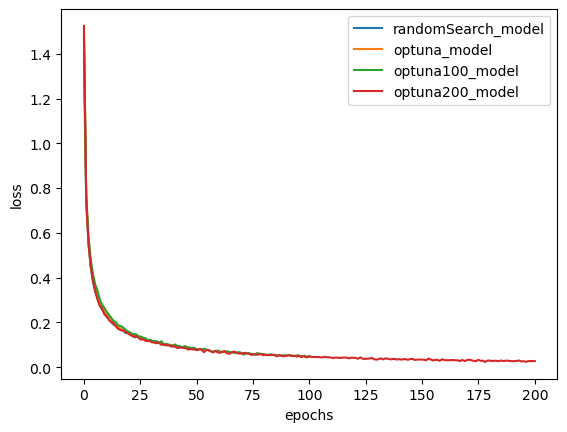

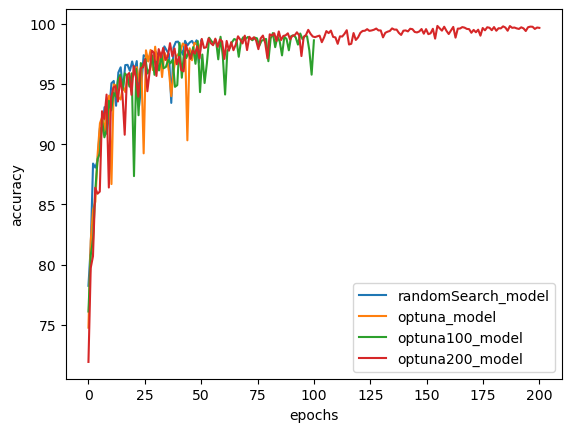

In [6]:
random_search_model_results_files_paths = ['CNN_results/graphs/randomSearch_model_loss_graph_results.csv', 'CNN_results/graphs/randomSearch_model_accuracy_graph_results.csv']
optuna_model_results_files_paths = ['CNN_results/graphs/optuna_model_loss_graph_results.csv', 'CNN_results/graphs/optuna_model_accuracy_graph_results.csv']
optuna_100model_results_files_paths = ['CNN_results/graphs/optuna100_model_loss_graph_results.csv', 'CNN_results/graphs/optuna100_model_accuracy_graph_results.csv']
optuna_200model_results_files_paths = ['CNN_results/graphs/optuna200_model_loss_graph_results.csv', 'CNN_results/graphs/optuna200_model_accuracy_graph_results.csv']

random_search_loss_results_path = random_search_model_results_files_paths[0]
random_search_accuracy_results_path = random_search_model_results_files_paths[1]

optuna_loss_results_path = optuna_model_results_files_paths[0]
optuna_accuracy_results_path = optuna_model_results_files_paths[1]

optuna100_loss_results_path = optuna_100model_results_files_paths[0]
optuna100_accuracy_results_path = optuna_100model_results_files_paths[1]

optuna200_loss_results_path = optuna_200model_results_files_paths[0]
optuna200_accuracy_results_path = optuna_200model_results_files_paths[1]

CNNplt.plot_results([random_search_loss_results_path, optuna_loss_results_path, optuna100_loss_results_path, optuna200_loss_results_path], "loss")
CNNplt.plot_results([random_search_accuracy_results_path, optuna_accuracy_results_path, optuna100_accuracy_results_path, optuna200_accuracy_results_path], "accuracy")

### <img src="icons/resized/noisy_dataset.png" style="height:50px;display:inline"> Noisy dataset:

In [12]:
def add_gaussian_noise_tensor(tensor, mean=0, std=0.02):
    noise = torch.randn_like(tensor) * std + mean
    noisy_tensor = tensor + noise
    return noisy_tensor

# Define the mean and standard deviation for Gaussian noise
mean_value = 0  # Mean of the Gaussian noise
std_value = 0.05  # Standard deviation of the Gaussian noise

# Define the transform function using transforms.Lambda
noisy_transform = transforms.Compose([
    transforms.Lambda(lambda x: add_gaussian_noise_tensor(x, mean=mean_value, std=std_value)),  # Add Gaussian noise to 
])

test_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    noisy_transform,
])

train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    noisy_transform,
    
])

valid_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    noisy_transform,
])

optuna_batch_size = 76

noisy_train_dataset = datasets.ImageFolder(root=local_root_dir + '/train/', transform=train_transform)
noisy_valid_dataset = datasets.ImageFolder(root=local_root_dir + '/val/', transform=valid_transform)
noisy_test_dataset = datasets.ImageFolder(root=local_root_dir + '/test/', transform=test_transform)

noisy_train_loader = torch.utils.data.DataLoader(noisy_train_dataset, batch_size=optuna_batch_size, shuffle=True)
noisy_valid_loader = torch.utils.data.DataLoader(noisy_valid_dataset, batch_size=optuna_batch_size, shuffle=False)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=optuna_batch_size, shuffle=False)

In [15]:
no_noise_model = plantDiseaseCNN()
if os.path.isfile('checkpoints/CNN_optuna_model_200epochs.pth'):
    checkpoint = torch.load('checkpoints/CNN_optuna_model_200epochs.pth')
    no_noise_model.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch']
no_noise_model.to(device)

std_values = [0, 0.05, 0.07, 0.09]
for std in std_values:
    std_value = std
    noisy_test_dataset = datasets.ImageFolder(root=local_root_dir + '/test/', transform=test_transform)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=optuna_batch_size, shuffle=False)
    test_accuracy, _ = calculate_accuracy(no_noise_model, noisy_test_loader, device)
    print(f"test accuracy for model with noisy test dataset with std {std}: {test_accuracy}")

test accuracy for model with noisy test dataset with std 0: 98.42883548983365
test accuracy for model with noisy test dataset with std 0.05: 8.248613678373383
test accuracy for model with noisy test dataset with std 0.07: 3.8123844731977816
test accuracy for model with noisy test dataset with std 0.09: 2.634011090573013


Like we see in the title above... our net crashed.

### <img src="icons/resized/train_on_noisy_dataset.png" style="height:50px;display:inline"> retrain model:
Retrain our best model with noisy train dataset.

In [28]:
optuna_p = 0.23436037814342595
optuna_lr = 0.00039047299241270366
batch_size = 76
epochs = 200
noisy_optuna_200model_loss = []
noisy_optuna_200model_accuracy = []
noisy_optuna_model_200epochs = train_model_for_test(noisy_train_loader, epochs, optuna_lr, optuna_p, noisy_optuna_200model_loss, noisy_optuna_200model_accuracy, "CNN_noisy_optuna_model_200epochs")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6023 | Training accuracy: 70.582% | Epoch Time: 133.73 secs
Epoch: 2 | Loss: 0.8791 | Training accuracy: 77.273% | Epoch Time: 128.11 secs
Epoch: 3 | Loss: 0.7023 | Training accuracy: 80.612% | Epoch Time: 128.01 secs
Epoch: 4 | Loss: 0.6057 | Training accuracy: 79.957% | Epoch Time: 124.23 secs
Epoch: 5 | Loss: 0.5448 | Training accuracy: 87.258% | Epoch Time: 126.23 secs
Epoch: 6 | Loss: 0.4951 | Training accuracy: 87.471% | Epoch Time: 121.86 secs
Epoch: 7 | Loss: 0.4548 | Training accuracy: 88.480% | Epoch Time: 125.33 secs
Epoch: 8 | Loss: 0.4336 | Training accuracy: 85.829% | Epoch Time: 123.36 secs
Epoch: 9 | Loss: 0.4035 | Training accuracy: 89.866% | Epoch Time: 124.24 secs
Epoch: 10 | Loss: 0.3894 | Training accuracy: 89.143% | Epoch Time: 122.77 secs
==> Saving model ...
Epoch: 11 | Loss: 0.3671 | Training accuracy: 89.467% | Epoch Time: 126.78 secs
Epoch: 12 | Loss: 0.3473 | Training accuracy: 90.078% | Epoch Time: 126.53 secs
Epoch: 13 | Loss: 0.3356 | T

test accuracy for a noisy test dataset with std 0: 92.2365988909427
test accuracy for a noisy test dataset with std 0.05: 97.4815157116451
test accuracy for a noisy test dataset with std 0.07: 90.0184842883549
test accuracy for a noisy test dataset with std 0.09: 60.7902033271719


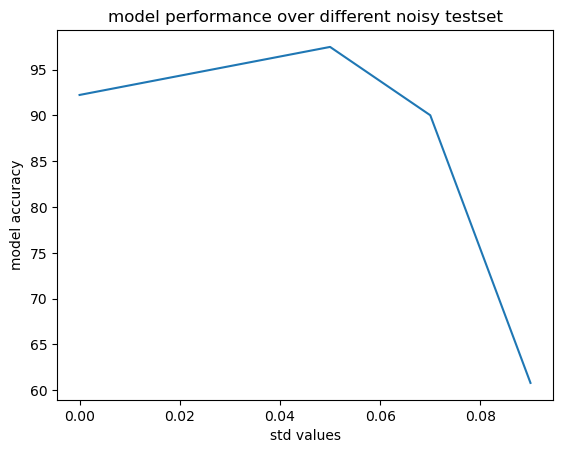

In [39]:
noisy_test_results_list = []
std_values = [0, 0.05, 0.07, 0.09]
for std_val in std_values:
    std_value = std_val
    noisy_test_dataset = datasets.ImageFolder(root=local_root_dir + '/test/', transform=test_transform)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=optuna_batch_size, shuffle=False)
    test_accuracy, _ = calculate_accuracy(noisy_optuna_model_200epochs, noisy_test_loader, device)
    noisy_test_results_list.append(test_accuracy)
    print(f"test accuracy for a noisy test dataset with std {std_value}: {test_accuracy}")

plt.plot(std_values, noisy_test_results_list)
plt.xlabel("std values")
plt.ylabel("model accuracy")
plt.title("model performance over different noisy testset")
plt.show()

### <img src="icons/resized/layers_output.png" style="height:50px;display:inline"> model layers output

predicted class: Grape___Esca_(Black_Measles)
model filters:


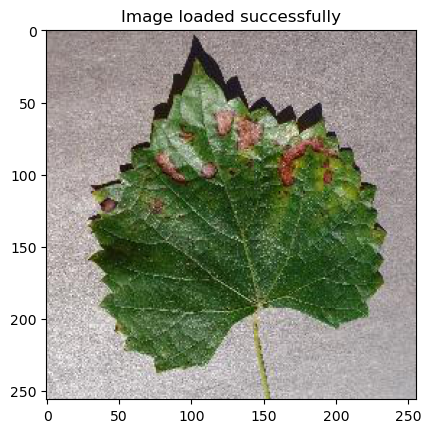

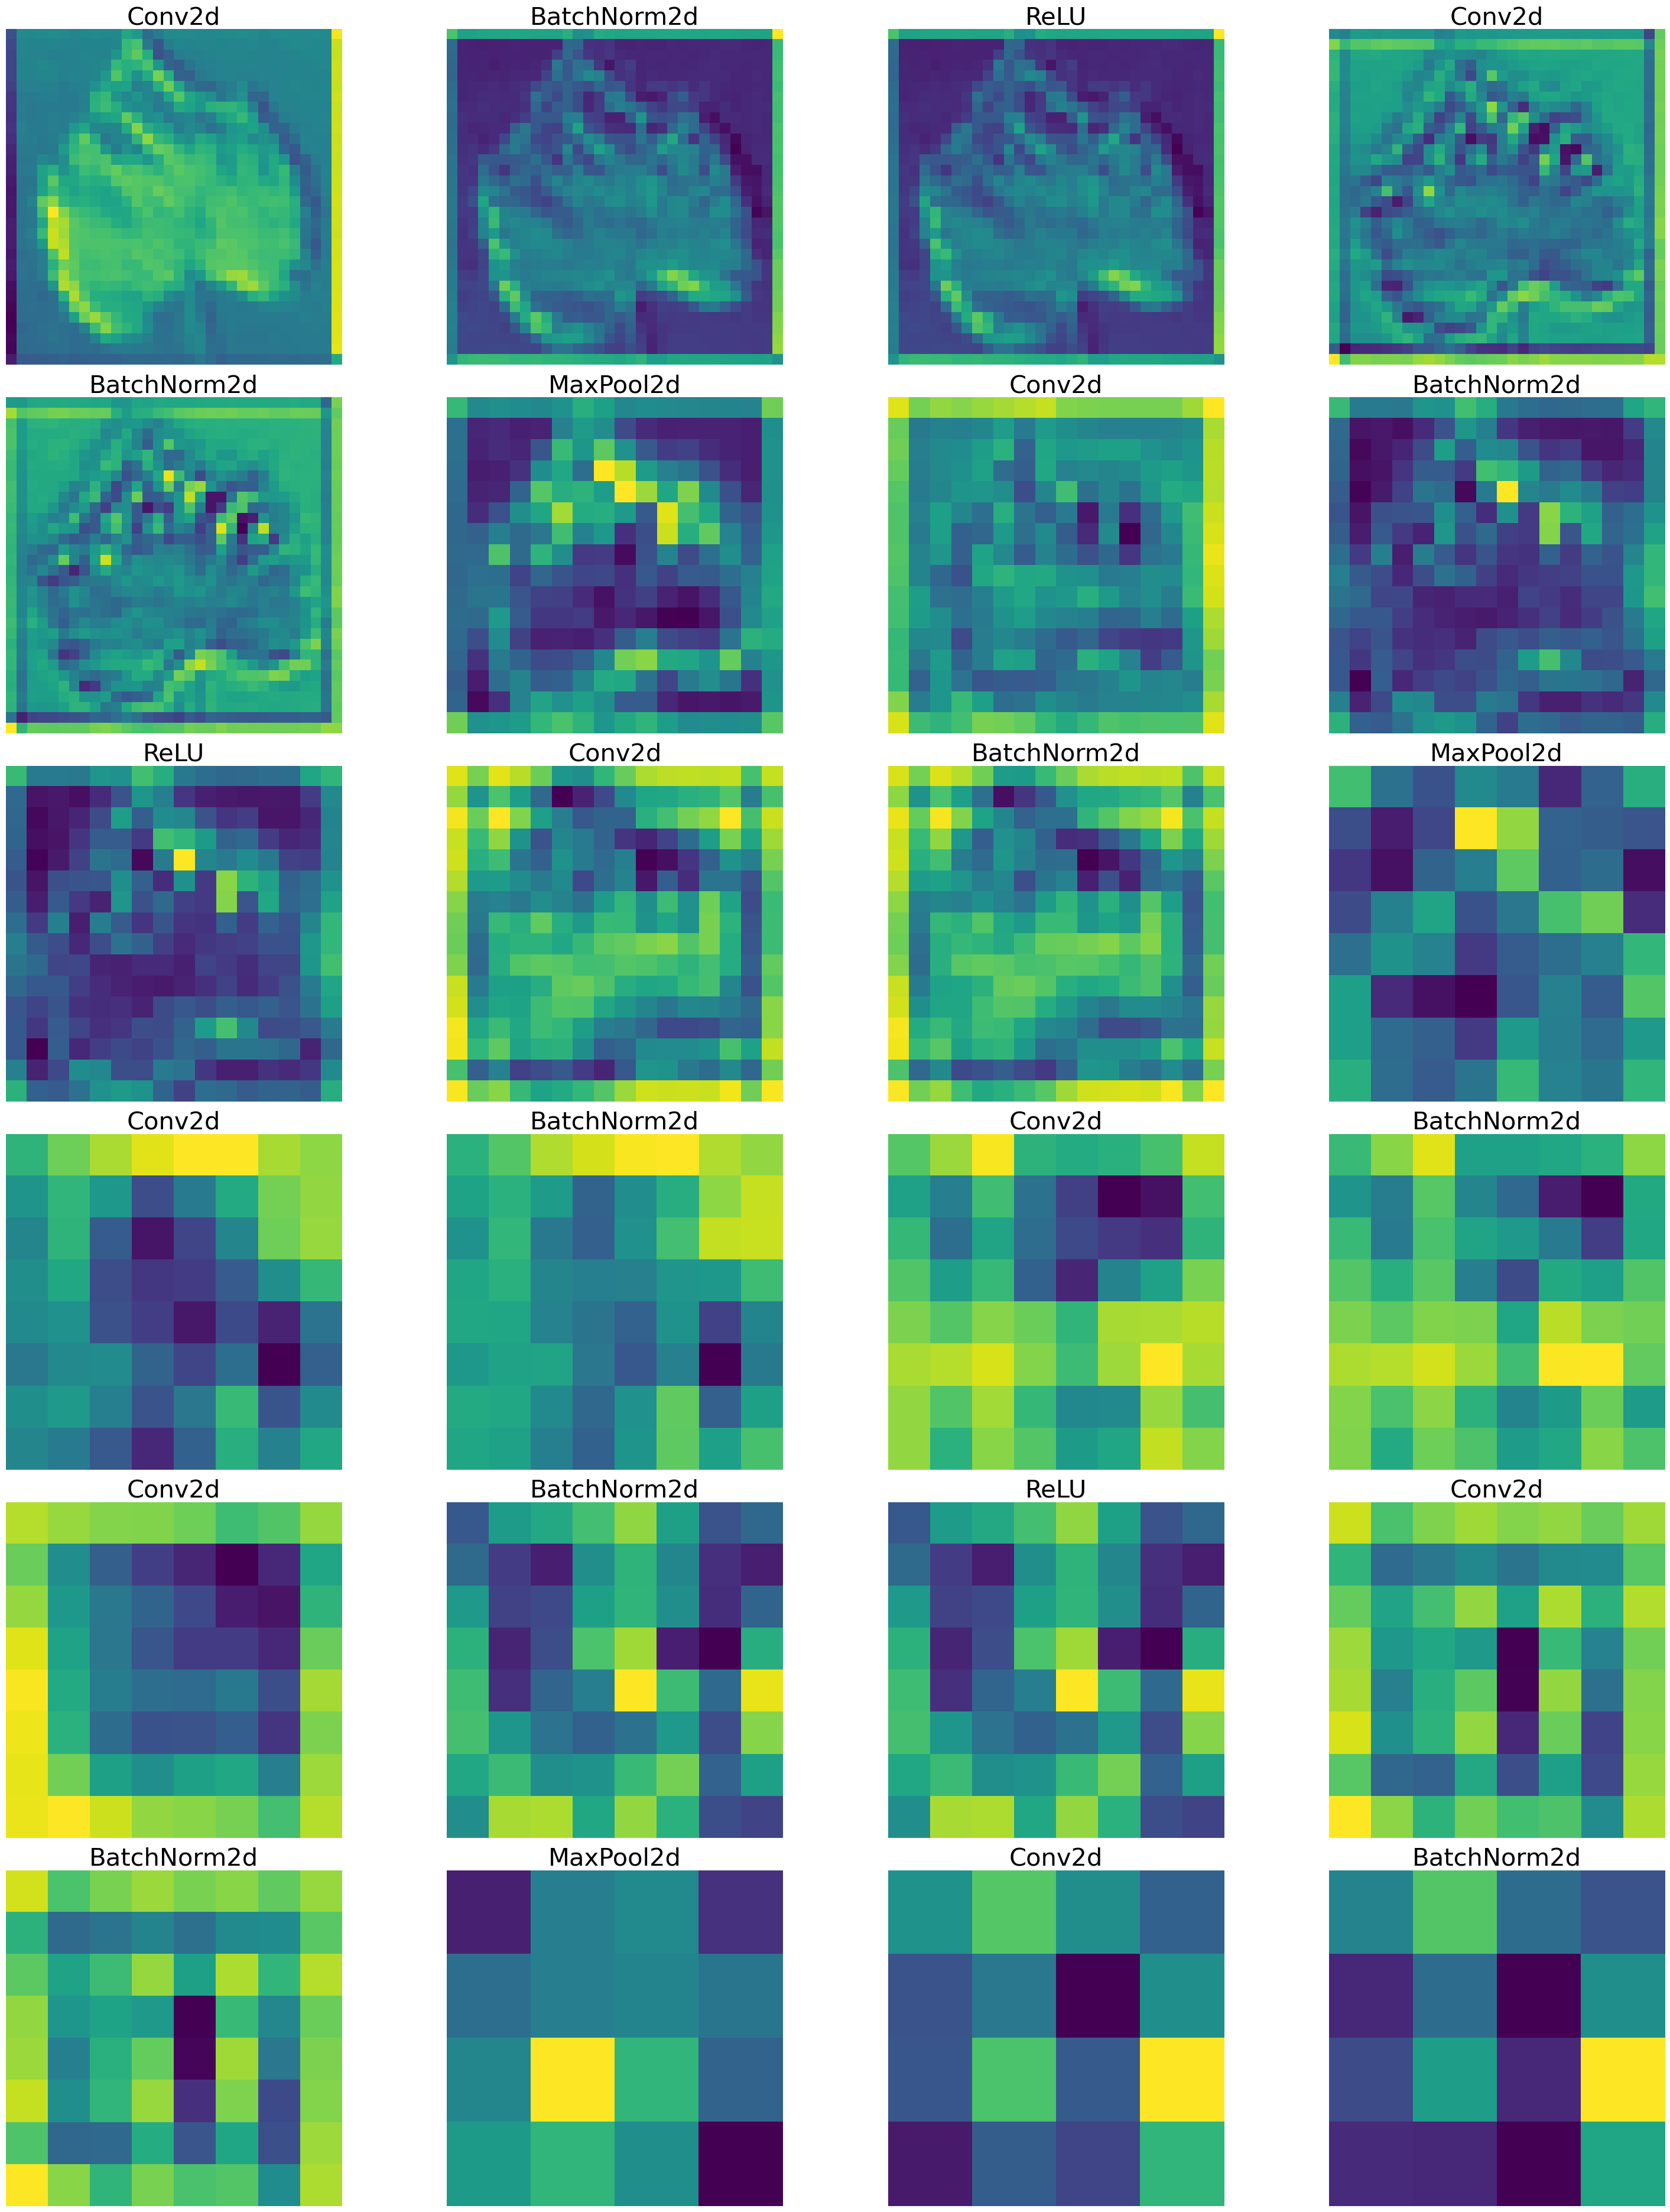

In [357]:
temp_model = plantDiseaseCNN()
if os.path.isfile('checkpoints/CNN_optuna_model_200epochs.pth'):
    checkpoint = torch.load('checkpoints/CNN_optuna_model_200epochs.pth')
    temp_model.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch']
temp_model.to(device)
dir_label = 'Grape___Esca_(Black_Measles)'
sample_image = load_image(local_root_dir + '/test/' + dir_label + '/0b2d8af7-af0b-4192-b60c-5a355b762c65___FAM_B.Msls 4201.JPG')
prep_img = normalize(sample_image, device)
print("predicted class:", test_dataset.classes[int(predict(prep_img, temp_model))])
print("model filters:")
layer_outputs(prep_img, temp_model)

### <img src="icons/resized/filters.png" style="height:50px;display:inline"> model filters

layer name - Conv2d


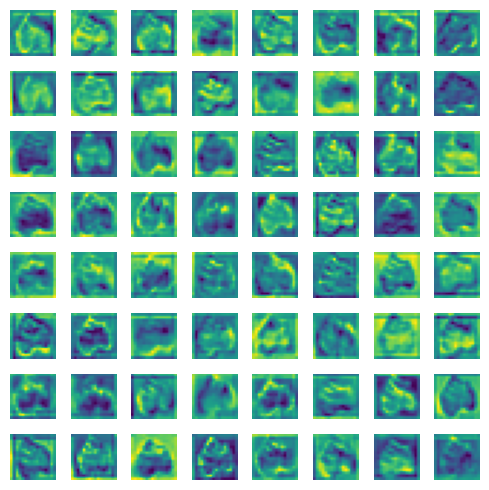

In [439]:
filter_model = plantDiseaseCNN()
if os.path.isfile('checkpoints/CNN_noisy_optuna_model_200epochs.pth'):
    checkpoint = torch.load('checkpoints/CNN_noisy_optuna_model_200epochs.pth')
    filter_model.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch']
filter_model.to(device)
model = filter_model
filter_outputs(prep_img, model, 6)